# VAE distribution conversion example

Note: This notebook is designed to run with CPU (no GPU) runtime.

Import modules.

In [1]:
import os, random
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, losses
from sklearn import datasets

random.seed(20230629)
np.random.seed(20230629)
tf.random.set_seed(20230629)

plt.rcParams.update({'font.size': 10})

Generate the "Moons" dataset.

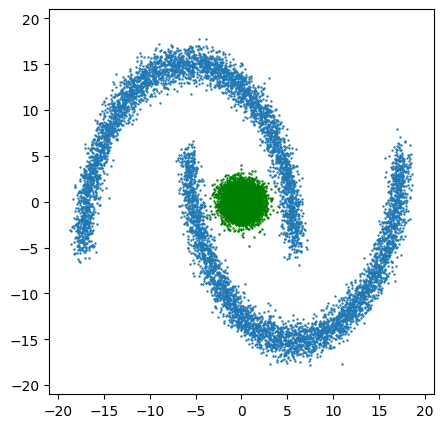

In [2]:
data = datasets.make_moons(8000, noise=0.05)[0].astype('float32')
norm = layers.Normalization()
norm.adapt(data)
train_data = norm(data) * 10
normal_samples = np.random.multivariate_normal(
    [0, 0], [[1, 0], [0, 1]], size=8000)

fig = plt.figure(figsize=(5, 5))
subplot = fig.add_subplot(1, 1, 1)
subplot.set_xlim((-21, 21))
subplot.set_ylim((-21, 21))
subplot.set_aspect('equal')
_ = subplot.scatter(train_data[:, 0], train_data[:, 1], s=0.5)
_ = subplot.scatter(normal_samples[:, 0], normal_samples[:, 1],
                color='green', s=0.5)

Define the encoder.

In [3]:
encoder = models.Sequential(name='encoder')
encoder.add(layers.Input(shape=(2,), name='encoder_input'))
encoder.add(layers.Dense(64, name='expand'))
encoder.add(layers.Dense(64, activation='relu', name='feedforward1'))
encoder.add(layers.Dense(64, activation='relu', name='feedforward2'))
encoder.add(layers.Dense(64, activation='relu', name='feedforward3'))
encoder.add(layers.Dense(64, activation='relu', name='feedforward4'))
encoder.add(layers.Dense(4, name='mean_and_log_var'))

encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ expand (Dense)                       │ (None, 64)                  │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feedforward1 (Dense)                 │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feedforward2 (Dense)                 │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feedforward3 (Dense)                 │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feedforward4 (Dense)                 │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mean_and_log_var (Dense)             │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,092 (66.77 KB)

 Trainable params: 17,092 (66.77 KB)

 Non-trainable params: 0 (0.00 B)

Define the sampler.

In [4]:
def get_samples(x): # x: encoder output
    num_examples = tf.shape(x)[0]
    means, log_vars = x[:, 0:2], x[:, 2:4]
    std_samples = tf.random.normal(shape=(num_examples, 2))
    samples = means + tf.exp(0.5 * log_vars) * std_samples
    return samples

sampler = models.Sequential(name='sampler')
sampler.add(layers.Input(shape=(4,), name='sampler_input'))
sampler.add(layers.Lambda(get_samples, name='sampled_embedding'))

sampler.summary()

Model: "sampler"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sampled_embedding (Lambda)           │ (None, 2)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Define the decoder.

In [5]:
decoder = models.Sequential(name='decoder')
decoder.add(layers.Input(shape=(2,), name='decoder_input'))
decoder.add(layers.Dense(64, name='expand'))
decoder.add(layers.Dense(64, activation='relu', name='feedforward1'))
decoder.add(layers.Dense(64, activation='relu', name='feedforward2'))
decoder.add(layers.Dense(64, activation='relu', name='feedforward3'))
decoder.add(layers.Dense(64, activation='relu', name='feedforward4'))
decoder.add(layers.Dense(2, name='output'))

decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ expand (Dense)                       │ (None, 64)                  │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feedforward1 (Dense)                 │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feedforward2 (Dense)                 │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feedforward3 (Dense)                 │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ feedforward4 (Dense)                 │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,962 (66.26 KB)

 Trainable params: 16,962 (66.26 KB)

 Non-trainable params: 0 (0.00 B)

Define Variational AutoEncoder by combining the encoder, the sampler and the decoder.

In [6]:
model_inputs = encoder.inputs[0]
model_outputs = layers.Concatenate(name='prediction_with_mean_log_var')(
    [encoder(model_inputs), decoder(sampler(encoder(model_inputs)))])

model = models.Model(inputs=model_inputs, outputs=model_outputs,
                     name='Variational_AutoEncoder')
model.summary()

Model: "Variational_AutoEncoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, 2)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder (Sequential)      │ (None, 4)              │         17,092 │ encoder_input[0][0],   │
│                           │                        │                │ encoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampler (Sequential)      │ (None, 2)              │              0 │ encoder[1][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder (Sequential)      │ (None, 2)              │         16,962 │ sampler[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ prediction_with_mean_log… │ (None, 6)              │              0 │ encoder[0][0],         │
│ (Concatenate)             │                        │                │ decoder[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 34,054 (133.02 KB)

 Trainable params: 34,054 (133.02 KB)

 Non-trainable params: 0 (0.00 B)

Define the custom loss funtion using MSE and the KL divergence.

In [7]:
def custom_loss(y_true, y_pred):
    mean, log_var, pred = y_pred[:, 0:2], y_pred[:, 2:4], y_pred[:, 4:6]
    reconstruction_loss = losses.mse(y_true, pred)
    kl_loss = tf.reduce_mean(tf.reduce_sum(
        -0.5 * (1 + log_var - tf.square(mean) - tf.exp(log_var)), axis=1))
    loss = reconstruction_loss + 0.8 * kl_loss
    return loss

Compile the model using the Adam optimizer and the custom loss function.

In [8]:
model.compile(optimizer='adam', loss=custom_loss)

Train the model

CPU times: user 1min 9s, sys: 4.4 s, total: 1min 13s
Wall time: 1min 2s


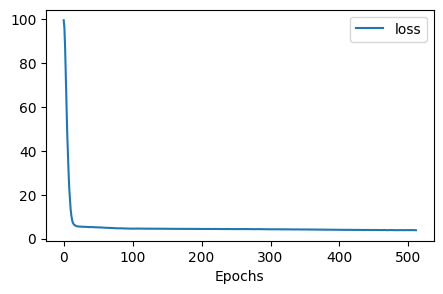

In [9]:
%%time
history = model.fit(train_data, train_data,
                    batch_size=2000, epochs=512, verbose=0)

df = DataFrame({'loss': history.history['loss']})
df.index.name = 'Epochs'
_ = df.plot(figsize=(5, 3))

Show the embeddings of training data.

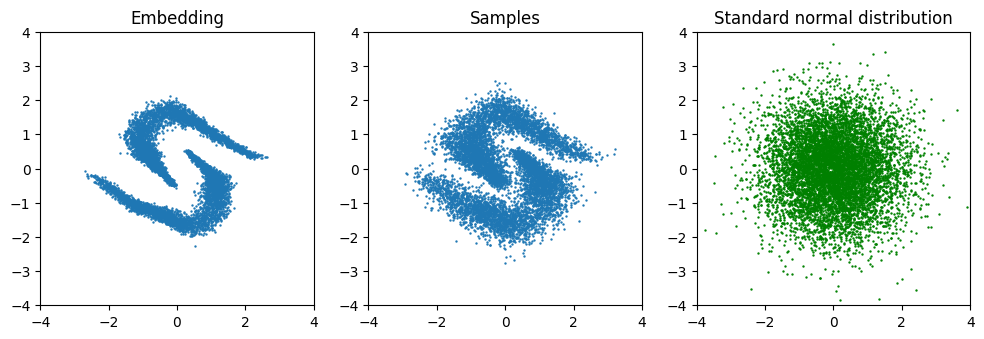

In [10]:
embeddings = encoder.predict(train_data, verbose=0)
samples = sampler.predict(embeddings, verbose=0)
embeddings = embeddings[:, :2]

fig = plt.figure(figsize=(12, 4))
subplot = fig.add_subplot(1, 3, 1)
subplot.set_xlim((-4, 4))
subplot.set_ylim((-4, 4))
subplot.set_aspect('equal')
subplot.set_title('Embedding')
_ = subplot.scatter(embeddings[:, 0], embeddings[:, 1], s=0.5)

subplot = fig.add_subplot(1, 3, 2)
subplot.set_xlim((-4, 4))
subplot.set_ylim((-4, 4))
subplot.set_aspect('equal')
subplot.set_title('Samples')
_ = subplot.scatter(samples[:, 0], samples[:, 1], s=0.5)

subplot = fig.add_subplot(1, 3, 3)
subplot.set_xlim((-4, 4))
subplot.set_ylim((-4, 4))
subplot.set_aspect('equal')
subplot.set_title('Standard normal distribution')
_ = subplot.scatter(normal_samples[:, 0], normal_samples[:, 1],
                    color='green', s=0.5)

Compare with the original data.

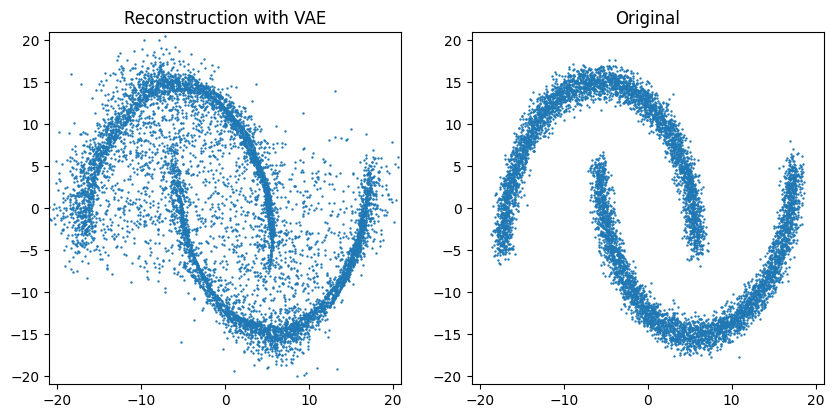

In [11]:
reconstruction = decoder.predict(normal_samples, verbose=0)

fig = plt.figure(figsize=(10, 5))
subplot = fig.add_subplot(1, 2, 1)
subplot.set_xlim((-21, 21))
subplot.set_ylim((-21, 21))
subplot.set_aspect('equal')
subplot.set_title('Reconstruction with VAE')
subplot.scatter(reconstruction[:, 0], reconstruction[:, 1], s=0.5)

subplot = fig.add_subplot(1, 2, 2)
subplot.set_xlim((-21, 21))
subplot.set_ylim((-21, 21))
subplot.set_aspect('equal')
subplot.set_title('Original')
_ = subplot.scatter(train_data[:, 0], train_data[:, 1], s=0.5)